In [1]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
x = utils.get_data(test=True)
#x.single_cell_growth()


In [3]:
df = x.get_positions()
df

,ID,type,x,y,z
0,95,2,0.000026,0.000020,0.000001
1,53,2,0.000024,0.000004,0.000003
2,62,2,0.000042,0.000006,0.000003
3,45,2,0.000027,0.000016,0.000003
4,26,1,0.000035,0.000003,0.000004
...,...,...,...,...,...
111,3,1,0.000096,0.000088,0.000006
112,110,2,0.000094,0.000093,0.000007
113,1,1,0.000053,0.000096,0.000008
114,89,2,0.000079,0.000090,0.000008


In [51]:

x.h5['type']['0'].__array__()

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2,
       1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2])

In [18]:
def get_neighbor_distance(id,timepoint):
    df = x.get_positions(timepoint)
    temp = (df[df.ID ==id][['x','y','z']].squeeze() - df[df.ID !=id][['x','y','z']])**2
    dist = pd.Series(np.sqrt(temp.x + temp.y + temp.z),name='Distance')
    return pd.concat([df[df.ID !=id][['ID','type']],dist],axis=1).reset_index(drop=True)
neigh = get_neighbor_distance(45,10000)
neigh

,ID,type,Distance
0,211,2,0.000005
1,649,2,0.000005
2,388,2,0.000004
3,376,2,0.000005
4,650,2,0.000013
...,...,...,...
684,491,2,0.000090
685,590,2,0.000087
686,330,2,0.000087
687,532,2,0.000090


<AxesSubplot:xlabel='Distance', ylabel='Density'>

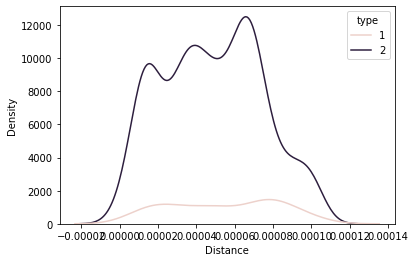

In [22]:
sns.kdeplot(data=neigh,x='Distance',hue='type')

In [30]:
df.query('ID == 95')[['x','y','z']].T.shape

(3, 1)

In [31]:
df.loc[df.ID== 95][['x','y','z']].squeeze()

x    0.000026
y    0.000020
z    0.000001
Name: 0, dtype: float64

In [29]:
df.loc[0].shape

(4,)

In [25]:
(df.loc[0][['x','y','z']] - df.loc[df.index !=0][['x','y','z']])**2

,x,y,z
1,1.960000e-12,2.611456e-10,2.280100e-12
2,2.722500e-10,1.985281e-10,4.080400e-12
3,8.100000e-13,1.600000e-11,4.243600e-12
4,7.744000e-11,3.048516e-10,7.452900e-12
5,1.392400e-10,8.410000e-12,6.200100e-12
...,...,...,...
111,4.970250e-09,4.583290e-09,2.342560e-11
112,4.637610e-09,5.329000e-09,3.306250e-11
113,7.398400e-10,5.776000e-09,4.225000e-11
114,2.851560e-09,4.900000e-09,5.372890e-11


In [27]:
df.loc[df.index !=0][['x','y','z']]

,x,y,z
1,0.000024,0.000004,0.000003
2,0.000042,0.000006,0.000003
3,0.000027,0.000016,0.000003
4,0.000035,0.000003,0.000004
5,0.000038,0.000023,0.000004
...,...,...,...
111,0.000096,0.000088,0.000006
112,0.000094,0.000093,0.000007
113,0.000053,0.000096,0.000008
114,0.000079,0.000090,0.000008


In [ ]:
""" light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max = 0.047*24 #2.25e-05# 1/d
K_m_light = 3.5e-04
K_m_co2 = 5e-2
def monod_func(y,t):
    return y*mu_max * (light/(K_m_light + light)) * (co2/( K_m_co2 + co2))
t = np.linspace(df.index[0], df.index[-1],1000)
sol = odeint(monod_func, y0, t)
f, ax = plt.subplots(figsize=(9,6))
ax.plot(df.iloc[:,1],label=f'Data')
ax.plot(t,sol,ls='--',label=f'fit') """

In [14]:
x.single_cell_biomass

,id,type,time,biomass
0,95,2,0.000000,92.505631
1,95,2,0.277778,90.662882
2,95,2,0.555556,88.941568
3,95,2,0.833333,87.342844
4,95,2,1.111111,85.860407
...,...,...,...,...
11711,79,2,26.666667,132.590902
11712,79,2,26.944444,136.687773
11713,79,2,27.222222,140.810091
11714,79,2,27.500000,67.292851


array([2.59e-05, 2.45e-05, 4.24e-05, 2.68e-05, 3.47e-05, 3.77e-05,
       2.12e-05, 3.95e-05, 4.21e-05, 2.59e-05, 4.26e-05, 3.28e-05,
       2.01e-05, 3.22e-05, 6.53e-06, 1.58e-05, 2.52e-05, 3.97e-05,
       3.53e-05, 4.08e-05, 7.88e-06, 4.95e-05, 2.24e-05, 1.73e-05,
       3.42e-05, 2.22e-05, 3.17e-05, 1.18e-06, 2.48e-05, 4.10e-05,
       3.77e-05, 2.83e-05, 5.81e-06, 3.08e-05, 2.02e-05, 4.53e-05,
       1.74e-05, 3.38e-05, 4.48e-05, 4.84e-05, 2.24e-05, 5.20e-06,
       4.45e-05, 2.31e-05, 1.86e-05, 4.97e-05, 2.94e-05, 1.56e-05,
       4.34e-05, 2.58e-05, 3.42e-05, 1.63e-05, 6.99e-05, 7.24e-05,
       9.18e-05, 6.52e-05, 6.39e-05, 9.63e-05, 7.82e-05, 9.43e-05,
       7.29e-05, 8.88e-05, 8.02e-05, 9.45e-05, 6.07e-05, 9.80e-05,
       6.24e-05, 5.34e-05, 9.87e-05, 5.73e-05, 6.97e-05, 9.77e-05,
       6.33e-05, 5.46e-05, 5.34e-05, 7.45e-05, 9.77e-05, 6.61e-05,
       7.81e-05, 5.37e-05, 9.70e-05, 5.58e-05, 6.33e-05, 7.36e-05,
       6.85e-05, 7.34e-05, 6.60e-05, 7.51e-05, 8.94e-05, 8.30e

In [18]:
ret_array.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115],
      dtype=int64)

In [19]:
comb = combinations(ret_array.index.values, 2)

In [20]:
for i in list(comb):
    print (i[0],i[1])

 74
36 75
36 76
36 77
36 78
36 79
36 80
36 81
36 82
36 83
36 84
36 85
36 86
36 87
36 88
36 89
36 90
36 91
36 92
36 93
36 94
36 95
36 96
36 97
36 98
36 99
36 100
36 101
36 102
36 103
36 104
36 105
36 106
36 107
36 108
36 109
36 110
36 111
36 112
36 113
36 114
36 115
37 38
37 39
37 40
37 41
37 42
37 43
37 44
37 45
37 46
37 47
37 48
37 49
37 50
37 51
37 52
37 53
37 54
37 55
37 56
37 57
37 58
37 59
37 60
37 61
37 62
37 63
37 64
37 65
37 66
37 67
37 68
37 69
37 70
37 71
37 72
37 73
37 74
37 75
37 76
37 77
37 78
37 79
37 80
37 81
37 82
37 83
37 84
37 85
37 86
37 87
37 88
37 89
37 90
37 91
37 92
37 93
37 94
37 95
37 96
37 97
37 98
37 99
37 100
37 101
37 102
37 103
37 104
37 105
37 106
37 107
37 108
37 109
37 110
37 111
37 112
37 113
37 114
37 115
38 39
38 40
38 41
38 42
38 43
38 44
38 45
38 46
38 47
38 48
38 49
38 50
38 51
38 52
38 53
38 54
38 55
38 56
38 57
38 58
38 59
38 60
38 61
38 62
38 63
38 64
38 65
38 66
38 67
38 68
38 69
38 70
38 71
38 72
38 73
38 74
38 75
38 76
38 77
38 78
38 79
38 8

In [21]:
def get_dist(ret_array):
    comb = combinations(ret_array.index.values, 2)
    distance = []
    id_set = []
    for i in list(comb):
        dx = (ret_array.x[i[0]] - ret_array.x[i[1]])**2
        dy = (ret_array.y[i[0]] - ret_array.y[i[1]])**2
        dz = (ret_array.z[i[0]] - ret_array.z[i[1]])**2
        distance.append(np.sqrt(dx+dy+dz))
        id_set.append((ret_array.ID[i[0]],ret_array.ID[i[1]]))
    return distance, id_set
distance, id_set = get_dist(ret_array)
distance.sort()
num_neighbors = 3
neighbors = list()
for i in range(num_neighbors):
    neighbors.append(distance[i])

In [22]:
distance, id_set = get_dist(ret_array)

In [23]:
distance.sort()

In [24]:
num_neighbors = 3
neighbors = list()
for i in range(num_neighbors):
    neighbors.append(distance[i])

In [25]:
neighbors

[2.3374344910606604e-06, 2.6687450234145675e-06, 3.1960913628993775e-06]

In [26]:
ret_array.ID.unique()

array([ 95,  53,  62,  45,  26,  47,  49,  37, 105,  68,  84,  10,  67,
        76, 116,  83, 111,  23,  64, 109,  51,   4,  16,  63,  78,  20,
        24,  29,  48,  91, 102,  36, 108,  22,  27,  30,  92,  38,  43,
        12,   8,   6,  17,  74,  19,  77,  21,  44,   5,  69,  86,  59,
        42,  13,  56,  65,  75,  71,  14, 103,   9,  18,  60,  58,  72,
        66,  87,  39,  93,  70, 106, 114,  97,  15,  85,  96,  52,  35,
       100,  80,  25, 112,  40,  73,  98, 101,  11,  61,  41,  88,  32,
        34, 115, 104, 107,  82,  50,  55,  57,  54,  31,   7,  99,  81,
         2,  46,  33,  90, 113,  28,  94,   3, 110,   1,  89,  79])

In [28]:
def get_dist(df):
    distance = []
    id_set = []
    for i in list(comb):
        dx = (ret_array.x[i[0]] - ret_array.x[i[1]])**2
        dy = (ret_array.y[i[0]] - ret_array.y[i[1]])**2
        dz = (ret_array.z[i[0]] - ret_array.z[i[1]])**2
        distance.append(np.sqrt(dx+dy+dz))
        id_set.append((ret_array.ID[i[0]],ret_array.ID[i[1]]))
    return distance, id_set

    

In [29]:
ret_array.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115],
      dtype=int64)

In [30]:
ret_array[ret_array.index !=0]

,ID,x,y,z
1,53,0.000024,0.000004,0.000003
2,62,0.000042,0.000006,0.000003
3,45,0.000027,0.000016,0.000003
4,26,0.000035,0.000003,0.000004
5,47,0.000038,0.000023,0.000004
...,...,...,...,...
111,3,0.000096,0.000088,0.000006
112,110,0.000094,0.000093,0.000007
113,1,0.000053,0.000096,0.000008
114,89,0.000079,0.000090,0.000008


In [31]:
temp = (ret_array.loc[0][['x','y','z']] - ret_array.loc[ret_array.index !=0][['x','y','z']])**2
np.sqrt(temp.x + temp.y + temp.z)


In [32]:
np.sqrt(temp.x + temp.y + temp.z)

1      0.000016
2      0.000022
3      0.000005
4      0.000020
5      0.000012
         ...   
111    0.000098
112    0.000100
113    0.000081
114    0.000088
115    0.000086
Length: 115, dtype: float64

In [33]:
ret_array.loc[0][['x','y','z']]

x    0.000026
y    0.000020
z    0.000001
Name: 0, dtype: float64

In [34]:
ret_array.loc[ret_array.index.values != 0][['x','y','z']]

,x,y,z
1,0.000024,0.000004,0.000003
2,0.000042,0.000006,0.000003
3,0.000027,0.000016,0.000003
4,0.000035,0.000003,0.000004
5,0.000038,0.000023,0.000004
...,...,...,...
111,0.000096,0.000088,0.000006
112,0.000094,0.000093,0.000007
113,0.000053,0.000096,0.000008
114,0.000079,0.000090,0.000008


In [35]:
trajectory['concentration']['suc']['0']

<HDF5 dataset "0": shape (5, 50, 50), type "<f8">

In [36]:
x.dims

[50, 50, 5]

In [37]:
CellInfo = {'cyano': {'GrowthRate' : round(0.06/3600,7),
    'min_length' : 1e-6, 'max_length' : 5e-6, 'Diameter' : 1e-6, 'Density' : 370,
    'Inertia' : {'ixx' : 0, 'iyy' : 0, 'izz' : 9.2e-23, 'ixy' : 0, 'ixz' : 0, 'iyz' : 0},
        'K_s' : {'light' : 3.5e-4,'o2' : 2e-4, 'suc' : 1e-2,'co2' : 1.38e-4},
    'Yield' : 0.55,'Maintenance' : 0,'Decay' : 0},
        'ecw': {'GrowthRate' : 2.7e-04,
    'min_length' : 1.94e-6, 'max_length' : 2.72e-6, 'Diameter' : 0.73e-6,'Density' : 236,
    'Inertia' : {'ixx' : 0, 'iyy' : 0, 'izz' : 9.2e-23, 'ixy' : 0, 'ixz' : 0, 'iyz' : 0},
        'K_s' : {'light' : 0,'o2' : 1e-3, 'suc' : 3.6,'co2' : 5e-2},
    'Yield' : 0.43,'Maintenance' : 9.50e-7,'Decay' : 2e-5}
} 
import json

In [38]:
json.dumps(CellInfo)

'{"cyano": {"GrowthRate": 1.67e-05, "min_length": 1e-06, "max_length": 5e-06, "Diameter": 1e-06, "Density": 370, "Inertia": {"ixx": 0, "iyy": 0, "izz": 9.2e-23, "ixy": 0, "ixz": 0, "iyz": 0}, "K_s": {"light": 0.00035, "o2": 0.0002, "suc": 0.01, "co2": 0.000138}, "Yield": 0.55, "Maintenance": 0, "Decay": 0}, "ecw": {"GrowthRate": 0.00027, "min_length": 1.94e-06, "max_length": 2.72e-06, "Diameter": 7.3e-07, "Density": 236, "Inertia": {"ixx": 0, "iyy": 0, "izz": 9.2e-23, "ixy": 0, "ixz": 0, "iyz": 0}, "K_s": {"light": 0, "o2": 0.001, "suc": 3.6, "co2": 0.05}, "Yield": 0.43, "Maintenance": 9.5e-07, "Decay": 2e-05}}'

In [47]:
test

{'cyano': {'GrowthRate': 1.67e-05,
  'min_length': 1e-06,
  'max_length': 5e-06,
  'Diameter': 1e-06,
  'Density': 370,
  'Inertia': {'ixx': 0,
   'iyy': 0,
   'izz': 9.2e-23,
   'ixy': 0,
   'ixz': 0,
   'iyz': 0},
  'K_s': {'light': 0.00035, 'o2': 0.0002, 'suc': 0.01, 'co2': 0.000138},
  'Yield': 0.55,
  'Maintenance': 0,
  'Decay': 0},
 'ecw': {'GrowthRate': 0.00027,
  'min_length': 1.94e-06,
  'max_length': 2.72e-06,
  'Diameter': 7.3e-07,
  'Density': 236,
  'Inertia': {'ixx': 0,
   'iyy': 0,
   'izz': 9.2e-23,
   'ixy': 0,
   'ixz': 0,
   'iyz': 0},
  'K_s': {'light': 0, 'o2': 0.001, 'suc': 3.6, 'co2': 0.05},
  'Yield': 0.43,
  'Maintenance': 9.5e-07,
  'Decay': 2e-05}}

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jonathan\\.nufeb_tools\\data\\run_26_90_83.pkl'

In [59]:
x.metadata['Dimensions']

[0.0001, 0.0001, 1e-05]

NameError: name 'metadata' is not defined

In [53]:
l = list(x.dims)

In [54]:
l += [l.pop(0)]

In [55]:
l

[50, 5, 50]

NameError: name 'metadata' is not defined

In [60]:
grid = [np.linspace(0,x.metadata['Dimensions'][i],l[i]) for i in range(3)]

In [61]:
grid

[array([0.00000000e+00, 2.04081633e-06, 4.08163265e-06, 6.12244898e-06,
        8.16326531e-06, 1.02040816e-05, 1.22448980e-05, 1.42857143e-05,
        1.63265306e-05, 1.83673469e-05, 2.04081633e-05, 2.24489796e-05,
        2.44897959e-05, 2.65306122e-05, 2.85714286e-05, 3.06122449e-05,
        3.26530612e-05, 3.46938776e-05, 3.67346939e-05, 3.87755102e-05,
        4.08163265e-05, 4.28571429e-05, 4.48979592e-05, 4.69387755e-05,
        4.89795918e-05, 5.10204082e-05, 5.30612245e-05, 5.51020408e-05,
        5.71428571e-05, 5.91836735e-05, 6.12244898e-05, 6.32653061e-05,
        6.53061224e-05, 6.73469388e-05, 6.93877551e-05, 7.14285714e-05,
        7.34693878e-05, 7.55102041e-05, 7.75510204e-05, 7.95918367e-05,
        8.16326531e-05, 8.36734694e-05, 8.57142857e-05, 8.77551020e-05,
        8.97959184e-05, 9.18367347e-05, 9.38775510e-05, 9.59183673e-05,
        9.79591837e-05, 1.00000000e-04]),
 array([0.0e+00, 2.5e-05, 5.0e-05, 7.5e-05, 1.0e-04]),
 array([0.00000000e+00, 2.04081633e-07,

In [62]:
ret_array[ret_array.ID ==95]['x'].values[0]

2.59e-05

In [63]:
ret_array.loc[0]['x']

2.59e-05

In [148]:
def get_grid_idx(array,value):
    """
    Find the nutrient grid index value. Taken from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array.

    Args:
        array (numpy.array):
            1D Array containing the grid positions
        value (float):
            Cell location to map to the grid
    Returns:
        index (int):
            Grid index
    """
    n = len(array)

    jl = 0# Initialize lower
    ju = n-1# and upper limits.
    while (ju-jl > 1):# If we are not yet done,
        jm=(ju+jl) >> 1# compute a midpoint with a bitshift
        if (value >= array[jm]):
            jl=jm# and replace either the lower limit
        else:
            ju=jm# or the upper limit, as appropriate.
        # Repeat until the test condition is satisfied.
    if (value == array[0]):# edge cases at bottom
        return 0
    elif (value == array[n-1]):# and top
        return n-1
    else:
        return jl

In [149]:
get_grid_idx(grid[2],ret_array.loc[0]['y'])

3

In [95]:
grid[0][12]

2.448979591836735e-05

In [103]:
trajectory['concentration']['suc']['1000'][0,12,0]

0.12523104535199808

In [169]:
grid = [np.linspace(0,metadata['Dimensions'][x],l[x]) for x in range(3)]
grid_loc = [get_grid_idx(grid[i],ret_array[ret_array.ID ==95][d].values[0]) for i,d in enumerate(['x','y','z'])]

In [170]:
grid_loc

[12, 9, 0]

In [146]:
trajectory['concentration']['suc']['1000'][grid_loc[2],grid_loc[0],grid_loc[1]]

0.1326231307024827

In [171]:
def get_local_con(trajectory,nutrient,timestep,cellID):
    grid = [np.linspace(0,metadata['Dimensions'][x],l[x]) for x in range(3)]
    grid_loc = [get_grid_idx(grid[i],ret_array[ret_array.ID ==cellID][d].values[0]) for i,d in enumerate(['x','y','z'])]
    return trajectory['concentration'][nutrient][str(timestep)][grid_loc[2],grid_loc[0],grid_loc[1]]

In [172]:
get_local_con(trajectory,'suc',0,1)

3.42e-20

In [181]:
timepoints = [key for key in trajectory['concentration']['co2'].keys()]
timepoints.sort(key=int)

In [321]:
df = x.single_cell_biomass
#df = df[df.id == 95]
df


,id,type,time,biomass
0,95,2,0.000000,92.505631
1,95,2,0.277778,90.662882
2,95,2,0.555556,88.941568
3,95,2,0.833333,87.342844
4,95,2,1.111111,85.860407
...,...,...,...,...
11711,79,2,26.666667,132.590902
11712,79,2,26.944444,136.687773
11713,79,2,27.222222,140.810091
11714,79,2,27.500000,67.292851


In [291]:
light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max_cy = 0.06
K_m_light = 3.5e-04
K_m_co2 = 5e-2
K_m_suc = 3.6
K_m_o2 = 0.001
mu_max_ecw = 0.972
o2 = 0.009
suc = 0.1
df.type.unique()[0]

1

In [306]:
#[get_local_con(trajectory,'suc',t,1) for t in timepoints]

In [380]:
x= utils.get_data(id='c/47146695')
x.single_cell_growth()
df = x.single_cell_biomass
